In [32]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from numpy.linalg import norm
import time
import random
from datetime import datetime
import re
import os
import urllib, io
from io import StringIO 
import string


In [103]:
import pickle
from tqdm import tqdm, tqdm_notebook
import sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import PIL
from PIL import Image
from sklearn.neighbors import NearestNeighbors

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image

import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [105]:
!pip install sklearn==0.23.1
sklearn.__version__

ERROR: Could not find a version that satisfies the requirement sklearn==0.23.1 (from versions: 0.0)
ERROR: No matching distribution found for sklearn==0.23.1


'0.22.2.post1'

In [98]:
# OPEN PIZZA DF PICKLE
# pizza_details = pickle.load(open('/content/drive/My Drive/ds/pizza_images/pizza_images/pizza_details.pickle', 'rb'))
big_pizza_details = pickle.load(open('/content/drive/My Drive/ds/pizza_images/pickles/big_pizza_details.pickle', 'rb'))
url_df = pickle.load(open('/content/drive/My Drive/ds/pizza_images/pickles/big_pizza_urls.pickle', 'rb'))
chicagoland = pickle.load(open('/content/drive/My Drive/ds/pizza_images/pickles/chicagoland.pickle', 'rb'))

# NMF items needed
doc_topic = pickle.load(open('/content/drive/My Drive/ds/pizza_images/pickles/pizza_doc_topic.pickle', 'rb'))
topic_word = pickle.load(open('/content/drive/My Drive/ds/pizza_images/pickles/pizza_topic_word.pickle', 'rb'))
nmf = pickle.load(open('/content/drive/My Drive/ds/pizza_images/pickles/pizza_nmf.pickle', 'rb'))
tfidf = pickle.load(open('/content/drive/My Drive/ds/pizza_images/pickles/pizza_tfidf.pickle', 'rb'))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator NMF from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [11]:
url_df.shape

(932, 3)

In [12]:
url_df

name  ...                                          photo_url
0                                Jet’s Pizza  ...  https://www.yelp.com/biz_photos/jets-pizza-chi...
1                                  Amedicano  ...  https://www.yelp.com/biz_photos/amedicano-chic...
2                             Pizza City USA  ...  https://www.yelp.com/biz_photos/pizza-city-usa...
3                                Bob’s Pizza  ...  https://www.yelp.com/biz_photos/bobs-pizza-chi...
4            Forno Rosso Pizzeria Napoletana  ...  https://www.yelp.com/biz_photos/forno-rosso-pi...
..                                       ...  ...                                                ...
927                                   Tô Pho  ...  https://www.yelp.com/biz_photos/tô-pho-chicago...
928                              Fratellos 2  ...  https://www.yelp.com/biz_photos/fratellos-2-ch...
929  Rookies All American Sports Pub & Grill  ...  https://www.yelp.com/biz_photos/rookies-all-am...
930                      Walmart Supercenter  ...  https://www.yelp.com/biz_photos/walmart-superc...
931                        Ewa’s Polish Deli  ...  https://www.yelp.com/biz_photos/ewas-polish-de...

[932 rows x 3 columns]

In [13]:
# splita = url_df.photo_url[0].split('/')
# splita[-1].split('?')[0]
url_df.photo_url[0].split('/')[-1].split('?')[0]
len(url_df)

932

## Add restaurant ID used in creation of the photo urls to link image recs back to DF

In [14]:
names = []
for idx in range(len(url_df)):
    names.append(url_df.photo_url[idx].split('/')[-1].split('?')[0])
names_df = pd.DataFrame(names)

In [88]:
total_df = pd.concat([names_df,chicagoland],axis=1)
total_df.rename(columns={0:'id'},inplace=True)
total_df.head()

id  ... topic
0                       jets-pizza-chicago  ...     1
1                        amedicano-chicago  ...     1
2                   pizza-city-usa-chicago  ...     6
3                       bobs-pizza-chicago  ...     5
4  forno-rosso-pizzeria-napoletana-chicago  ...     5

[5 rows x 18 columns]

## Now bring back the Resnet or Autoencoder to get top ____ recs and filter on closest suggestion or vice versa. In general, combine two models for recommendation overall

In [63]:
filenames = pickle.load(open('/content/drive/My Drive/ds/pizza_images/autoencoder/OGfilenames_images.pickle', 'rb'))
feature_list = pickle.load(open('/content/drive/My Drive/ds/pizza_images/autoencoder/OGfeatures-resnet.pickle','rb'))
class_ids = pickle.load(open('/content/drive/My Drive/ds/pizza_images/autoencoder/OGresnet_classids.pickle', 'rb'))
apart_features = pickle.load(open('/content/drive/My Drive/ds/pizza_images/autoencoder/features-resnet-apart.pickle', 'rb'))

In [26]:
model = ResNet50(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3),
                        pooling='max')

94773248/94765736 [==============================] - 1s 0us/step


In [84]:
# Helper function to get the classname
def classname(str):
    return str.split('/')[-2]


# Helper function to get the classname and filename
def classname_filename(str):
    return str.split('/')[-2] + '/' + str.split('/')[-1]


# Helper functions to plot the nearest images given a query image
def plot_images(filenames, distances):
    images = []
    rec_ids = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 10))
    columns = 4
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + filenames[i].split('/')[-1].split('.')[0])
        else:
            ax.set_title("Similar Image\n" + filenames[i].split('/')[-1].split('.')[0] +
                         "\nDistance: " +
                         str(float("{0:.2f}".format(distances[i]))))
        plt.imshow(image)

# Helper function to return restaurant ids for recommendations
def get_image_recs(img_path, num_recs):
  img_features = extract_features(img_path,model)
  distances, indices = neighbors.kneighbors([img_features])
  # Since this image is from outside our images, first image is ok to take as recommendation
  similar_image_paths = [filenames[indices[0][i]] for i in range(0, num_recs)]
  rec_ids = []
  for filename in similar_image_paths:
    rec_ids.append(filename.split('/')[-1].split('.')[0].split('_')[0])
  return rec_ids

# Helper function to extract resnet features from an image
def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path,
                         target_size=(input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

In [41]:
print(extract_features('/content/drive/MyDrive/ds/pizza_images/autoencoder/test/veranda_test.jpg',model))
print(apart_features)

[0.00178475 0.00101728 0.00843327 ... 0.00108938 0.00463534 0.03208936]
[0.00178475 0.00101728 0.00843327 ... 0.00108938 0.00463534 0.03208936]


In [72]:
neighbors = NearestNeighbors(n_neighbors=25, algorithm='brute', metric='euclidean').fit(feature_list)

In [87]:
image_recs = get_image_recs('/content/drive/MyDrive/ds/pizza_images/autoencoder/test/veranda_test.jpg',25)
image_recs

['pizza-castle-chicago',
 'calo-ristorante-chicago',
 'pizanos-pizza-chicago',
 'chicagos-pizza-chicago',
 'di-vitas-pizzeria-chicago',
 'crushed-pizzeria-chicago',
 'villa-rosa-pizza-kitchen-chicago',
 'ginos-east-south-loop-chicago',
 'dominos-chicago',
 'nella-pizza-e-pasta-chicago',
 'stunods-pizzeria-chicago',
 'giovannis-pizza-chicago',
 'villa-rosa-pizza-kitchen-chicago',
 'crushed-pizzeria-chicago',
 'italian-express-chicago',
 'mugs-pizza-and-ribs-chicago',
 'pizzeria-aroma-chicago',
 'pizzeria-serio-chicago',
 'pats-pizzeria-chicago',
 'villa-palermo-pizza-and-catering-chicago',
 'villa-palermo-pizza-chicago',
 'villa-rosa-pizza-kitchen-chicago',
 'ranallis-of-andersonville-chicago',
 'piece-brewery-and-pizzeria-chicago',
 'petes-pizza-chicago']

['/content/drive/MyDrive/ds/pizza_images/autoencoder/test/veranda_test.jpg', '/content/drive/MyDrive/ds/pizza_images/yelp_only/data/pizza-castle-chicago_5.jpeg', '/content/drive/MyDrive/ds/pizza_images/yelp_only/data/calo-ristorante-chicago_7.jpeg', '/content/drive/MyDrive/ds/pizza_images/yelp_only/data/pizanos-pizza-chicago_7.jpeg']


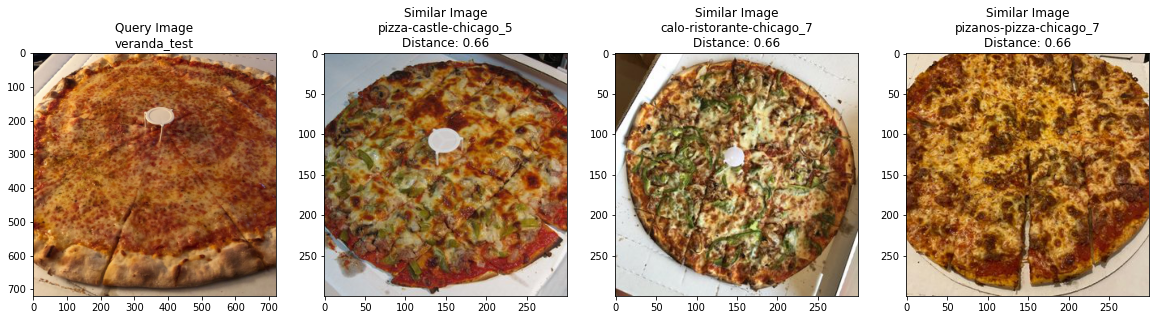

In [74]:
# Find nearest three neighbors for Apart image
distances, indices = neighbors.kneighbors([extract_features('/content/drive/MyDrive/ds/pizza_images/autoencoder/test/veranda_test.jpg',model)])
# Since this image is from outside our images, first image is ok to take as recommendation
similar_image_paths = ['/content/drive/MyDrive/ds/pizza_images/autoencoder/test/veranda_test.jpg'] + \
        [filenames[indices[0][i]] for i in range(0, 3)]
print(similar_image_paths)
plot_images(similar_image_paths, distances[0])

In [96]:
image_recs_df = total_df[total_df['id'].isin(image_recs) & (total_df['pizza_words'] != '')].reset_index()
image_recs_df.head(2)

index                                  id  ...   Italian topic
0     10            crushed-pizzeria-chicago  ...  0.030528     5
1    167  piece-brewery-and-pizzeria-chicago  ...  0.025163     2

[2 rows x 19 columns]

In [100]:
apart = 'The thin crust makes the pizza so "light" hahaha. The service at this place was absolutely terrible and the pizza wasn\'t any better than any other place. I worked at a pizza place for almost three years so I am usually incredibly sympathetic and patient with others in these situations, but this experience was just too bad. I called and asked if they had gluten free pizza and they said yes which was great! They came early, after about half an hour and I took the pizza up to my dorm. I opened the box and I saw the most despicable pizza I have ever seen. I called them, after the delivery man seemed to be fumbling around his phone for a few minutes and not making any progress, and they said they didn\'t have a knife to cut gluten free pizzas and it said that on the website. Why sell gluten free pizza if they can\'t even invest in a knife to cut it?!I just said okay and went upstairs and cut my pizza with a plastic fork; safe to say it didn\'t go well. The pizza itself was fine I guess but it definitely did not have extra cheese so it\'s a shame I had to pay for that. I guess maybe if you want to try their pizza eat in because there are lots of issues when you order out! Service is great for delivery and in store orders. \xa0Pizza is hot and tasty . \xa0The red sauce has that good fresh-ish acidic quality that is offset by a slight char in the crust. The pizza is thin. And for all you pizza snobs out there...pizza must be loved and understood in context. \xa0This place is good for the inexpensive, delicious and quick delivery pizza they have.FYI...I lived in Italy as a child and know Italian pizza. I\'m pretty sad to write this review as I\'ve had pizza from here before and thought it was fairly good. I will never patronize Apart again, which is sad because the pizza\'s not too bad. Of the 4 things best about pizza I had 3 this time. Thick crust pizza is artificial to Chicago. As a boy all the pizza here was thin. We ordered two 10 inch personal pizzas. It was really good neighborhood pizza. Our 8 year old is allergic to dairy and had never had pizza, which is a tragedy. \xa0We noticed that Apart is able to make their pizzas with vegan cheese, so we decided to head over and give it a shot. \xa0Now, I admit that I wasn\'t looking forward to eating a vegan cheese pizza. \xa0I imagined that it would taste like a cross between plastic and cardboard. \xa0You know what? \xa0It was actually good! \xa0They use Daiya vegan cheese and the taste and consistency was a lot like real cheese.We got the chance to talk with the owner and she mentioned that they really try to make a tasty alternative for people who cannot or choose not to have dairy. \xa0She said that they have experimented with different combinations and have found one that works. \xa0She was so friendly and it\'s obvious that she truly cares about the final product and making people happy.I can\'t believe I\'m saying it, but I\'m actually looking forward to my next vegan pie. \xa0I think we\'ve also set the kiddo up for a lifelong addiction to pizza. \xa0You\'re welcome, son. Apparently I\'ve thought about ordering from this place several times but just haven\'t been able to pull the trigger. \xa0Why? \xa0Well, first of all, it pains me to pay $20 for a medium pizza. \xa0Secondly, I\'m too impatient to wait for delivery.Last night everything changed. \xa0Well, I was still disgruntled about having to pay $20 for a medium, but I needed some cheesy goodness and could not waste any more money on Dominos. \xa0At least they don\'t charge a delivery fee and have easy ordering through GrubHub. \xa0I did try to cancel the order when GrubHub estimated delivery in 1.5 hours but Apart assured me it\'d be more like 45 minutes. \xa0OK, I could handle that.Sure enough, my pizza showed up in almost exactly 45 minutes. \xa0You know what, that was some awesome pizza. \xa0We ordered the Apart pizza (sausage, pepperoni and mushroom). \xa0You know when you walk past a pizza place and it smells so delicious that you start salivating? \xa0This pizza actually lives up to that smell. \xa0I\'m so glad that we decided to order meat on our pie because it was seasoned perfectly. \xa0I loved it.Now I see why people spend $20 on a medium. \xa0Just look at all the years I\'ve wasted on bad pizza. \xa0I\'m a new woman! This was my first time visiting Apart Pizza company and I was sorely disappointed. Above their counter they had a sign stating they had a Golden Grub for their Margherita pizza, but on the menu they had two types. The counter staff didn\'t know what their award winning pizza was so I opted for the Queen Margherita pizza.The pizza was rendered hideous by the sauce, a sloppy tomato-water that was simply and completely bland. The crust was good and topping fair, but the sauce killed the pizza.I will not go back. Disclaimer: \xa0I was not able to actually try the pizza. \xa0This review is about the customer service. \xa0Also, if I could, I would give zero stars. \xa0We ordered pizza for delivery at 7:30 on a Sunday evening and were given an eta of an hour from time ordered. \xa0By 9:00, my husband was calling asking where our pizzas were. \xa0He was then informed that they had delivered our pizzas to the wrong address. \xa0They then offered to re-make our pizzas and delivery them to us right away - they said 15 minutes. \xa0There are many things wrong with this exchange.1) THEY DID NOT CALL US TO INFORM US THAT OUR PIZZAS WERE DELIVERED TO THE WRONG ADDRESS!!! \xa0How can you run a business when you misdeliver a product and then not even INFORM your original customer? \xa0Had we not called, we would have sat here another hour wondering where our pizza was.2) They acted like this was not a big deal at all and that we should be happy accepting a pizza 2 hours after we ordered and pay full price for it. \xa0When we asked for some sort of deal, they told us we could cancel our order if we no longer wanted it. \xa0When my husband pushed for a manager, the manager offered us $5 off of our order. \xa0No thanks.3) They gave us an unrealistic estimate of when we could expect our re-made pizzas, which had we accepted, we would have again been disappointed by a longer than expected wait time. \xa0Unless Apart Pizza is now the proud owner of the first working teleporter, there is NO WAY they would have been able to re-make, cook, and deliver our pizzas within 15 minutes of the phone call. \xa0I was really disappointed with this experience to be honest, as I was really looking forward to trying the vegan option at Apart. \xa0What a disappointment. If there\'s one thing I\'m not, it\'s a fan of thin crust pizza. Part of the joy of being a true Chicagoan is knowing the difference between good pizza and... everything else. It seems silly to me to order thin crust pizza in a city known for it\'s deep dish. Last week, girls night out started off at Apart Pizza. Time for pizza! The first pizza we tried was the Cacciatore: Ham, pepperoni, bacon, onions and garlic. That pizza contained more fresh vegetables and feta, and was served with oven baked chicken breast on top that was so moist, I almost wanted to order strips of it to take home. I really liked the freshness of all of the ingredients, the uniqueness of the pizza combinations and toppings, how bright and clean the small dining space was, and that each pizza was better than the next. Having eaten more than I think I ever had in one sitting, I was not at all uncomfortably full as I usually am after eating my weight in deep dish pizza. There are so many pizzas, salads and desserts to choose from, I will definitely be back and would recommend this place to anyone We visited Apart Pizza after purchasing a Groupon. I was interested in the location in Edgewater that was advertised on the Groupon and on the website that had a great description of a gluten free pizza. The salads we ordered were delicious and a great value; the pizzas arrived and they were good sizes as well. The service was very friendly so don\'t discount this place if you live in the area, but for us to drive back into the city again for Apart Pizza probably won\'t be happening. It\'s not closed, but actually moved and is now Veranda on Thorndale. \xa0Same great pizza, not far at all! We\'ve been loyal customers to Apart for several years, telling lots of people in the Chicago-area that they had the best pizza around. Apart insisted that they can\'t cancel my order, and they still refused to offer any compensation for the fact that our pizza, which was ordered at 7:15, wasn\'t delivered until almost 10:15. Finding a good vegan pizza can also be a challenge! I order the vegetarian pizza, add onion, and substitute vegan cheese. My pizzas have been delivered hot, fresh, and tasty each time. I distinctly remember hearing the Apart Pizza delivery man downstairs in my courtyard yelling "Amanda! Pizza!" Now that\'s service I REALLY want to give this place a better review...but I really can\'t....We have given them several chances because the pizza is really good. One time they sent us a small instead of an extra large then made us wait an hour to "exchange" pizzas for our original size. That resulted in two hours of waiting for all of us to eat a cold rushed pizza and one of those hours was spent smelling the one we were supposed to turn in for the correct size. Then blamed the web ordering system for their confusion which they ask everyone to use (rather than Grub Hub which a note on their pizzas explains takes a percentage) saying their online system isn\'t very good. They also gave me a free coupon when the pesto pizza had taken so long, which I now understand was because they don\'t have any so they had to manifest it from the thin air ;) ... but wrote on it \xa0for a free "dessert". I\'m sitting here with the coupon clearly saying Pizza Apart on it and the words Dessert and the name of an employee Bianca... They were hard as a rock(I actually had to use a steak knife to cut them!), and super dry so that sauce would of made some of a difference.The pizza was just ok. The crust edges were cooked nice and crispy but the rest of the pizza seemed slightly underdone and was sloppy. I\'ll stick with my usual Ranallis or Antica Pizzaria if I want a close local pizza. Pizza is good. People handling phones with zero interaction skills. 16" specialty pizza with delivert, tax, tip. $33.Ill pass. My fiance and I had a random pizza craving last night at 9 PM, so we thought we\'d check this place out. We\'ve heard really good things about their thin crust pizza -- it\'s supposed to be as close to New York pizza as you can get -- and that\'s what we were in the mood for.The situation was a little awkward. But, we ordered our pizza and all went smoothly.As far as atmosphere, this place is pretty cool. Going here during a time when they aren\'t about to close would probably be fun, and they\'re a BYOB place, so it\'s definitely now on our radar for places to hang out.The pizza itself was delicious. If you\'re looking for an affordable thin-crust pizza, this is where you want to go. Their combos are significantly cheaper during their lunch time (you can get a pizza that serves 3-4 and a 2-liter coke for under $20), and they offer free shipping from 11 AM - 3 PM. Since we went late night, we\'re not sure how this is going to work out, but we\'re excited to try. We were happy with our pizza and can\'t wait to try out their garlic knots and dessert. January - when we shared our first of your pizzas together, but . . . I\'ve thrown away all my other pizza menus - I don\'t call them anymore, and want you to be the only pizza joint that delivers to my house. My new favorite pizza in the \'hood, hands down.Walked over, and had thoughts of eating in, but then saw "free delivery!" and my 7star, anchovie-pizza loving companion and I opted for the comfort of my couch instead and Apart\'s quick delivery to my hut!The pizza! I got salted out and had to offload a view of the \'chovies, but even left with the mushroom pizza, it was still excellent. Great lunch specials till 3 p.m. thin crust Pizza pretty tasty good service --- but without a smile like typically ChicagoThe place has a nice feel to it and you can write on the walls with chalkI must honestly admit I was very hungry when I left and went home and had a sandwich ...So this is not very filling food ( pizza in general) so consider it a snack not a meal '
apart = re.sub(r'\d+','',apart) # remove numbers
apart = apart.lower() #lower case
apart = re.sub(r'[^\w\s]', '',apart)
apart

'the thin crust makes the pizza so light hahaha the service at this place was absolutely terrible and the pizza wasnt any better than any other place i worked at a pizza place for almost three years so i am usually incredibly sympathetic and patient with others in these situations but this experience was just too bad i called and asked if they had gluten free pizza and they said yes which was great they came early after about half an hour and i took the pizza up to my dorm i opened the box and i saw the most despicable pizza i have ever seen i called them after the delivery man seemed to be fumbling around his phone for a few minutes and not making any progress and they said they didnt have a knife to cut gluten free pizzas and it said that on the website why sell gluten free pizza if they cant even invest in a knife to cut iti just said okay and went upstairs and cut my pizza with a plastic fork safe to say it didnt go well the pizza itself was fine i guess but it definitely did not h

In [101]:
# w.append(coffee.Review[0])
vt = tfidf.transform([apart]).todense() # 
tt1 = nmf.transform(vt)
doc_topic = image_recs_df[['Simple Delivery', 'Greek Places Serving Pizza', 'Beer Bars',
       'Deep Dish', 'Pizza Puffs', 'Tavern', 'NY/Detroit', 'Bar & Grill',
       'Italian']]
indices = pairwise_distances(tt1.reshape(1,-1),doc_topic,metric='cosine').argsort()
recs = list(indices[0][0:4])
image_recs_df.iloc[recs]
print('The pizza you liked was described as:', 'from Apart pizza.') #str(item)
print('\n')
print('Based on your input pizza I recommend you try:',image_recs_df.iloc[recs[0]]['name'],'located at',big_pizza_details.iloc[recs[0]]['address'],'.')
print('\n')
print('Based on your input pizza I recommend you try:',image_recs_df.iloc[recs[1]]['name'],'located at',big_pizza_details.iloc[recs[1]]['address'],'.')
print('\n')
print('Based on your input pizza I recommend you try:',image_recs_df.iloc[recs[2]]['name'],'located at',big_pizza_details.iloc[recs[2]]['address'],'.')

RecursionError: ignored

Number of images =  1698
Number of features per image =  2048


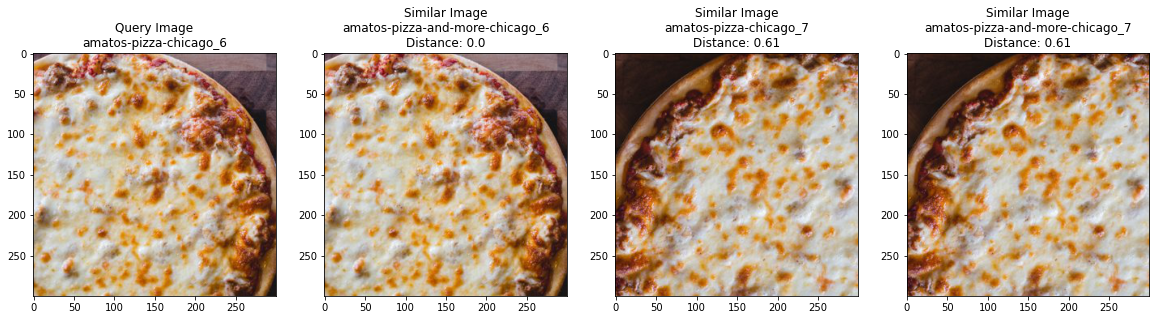

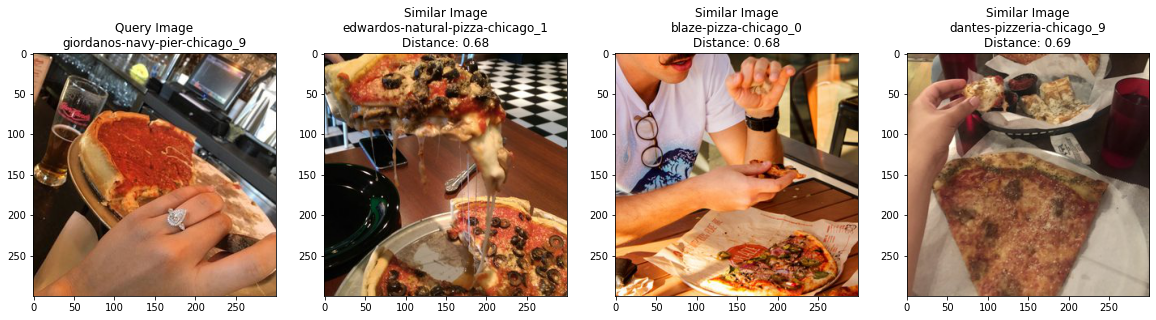

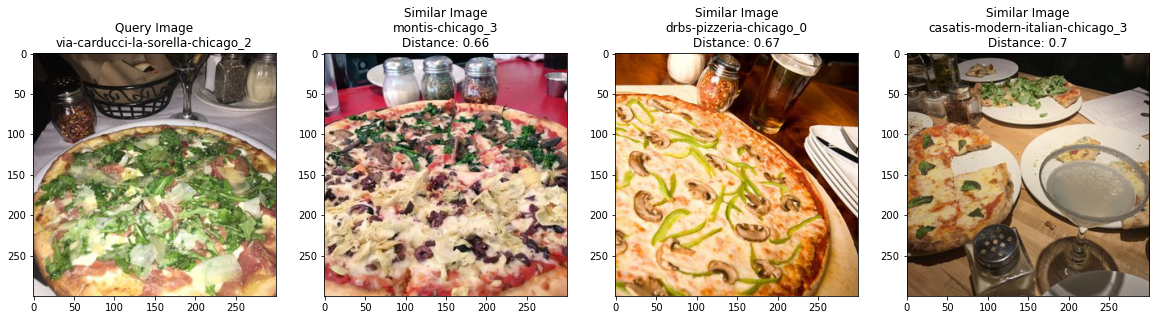

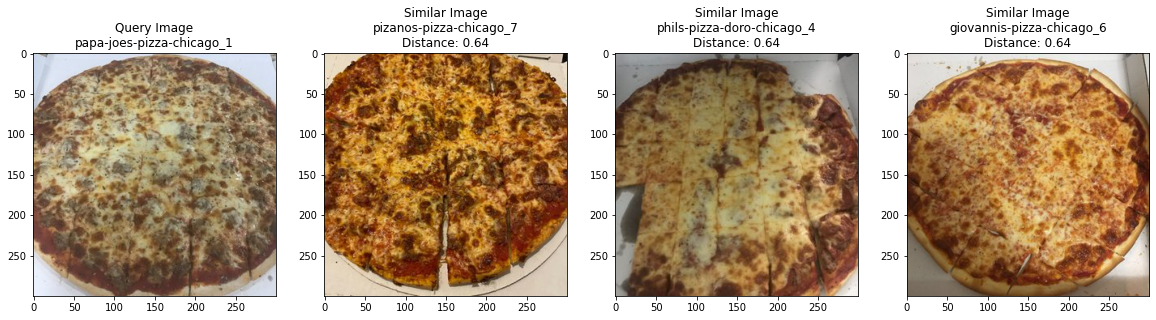

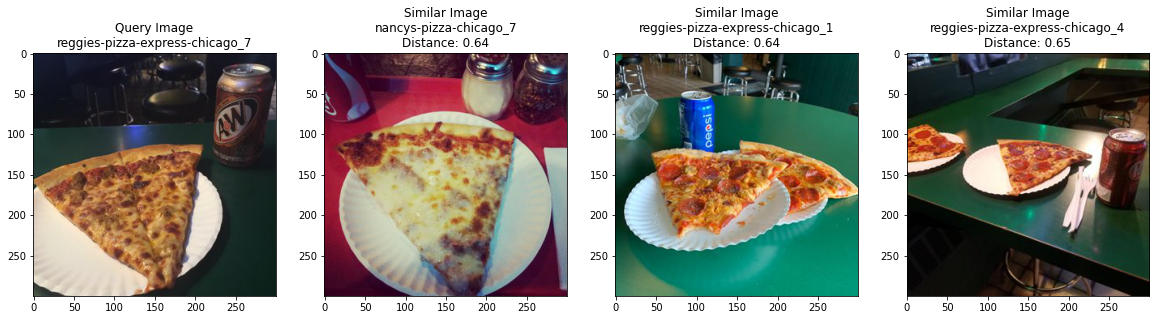

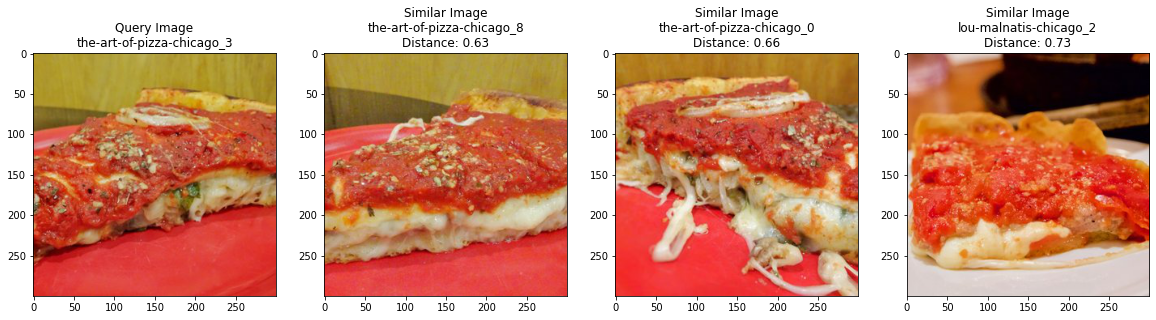

In [73]:
# Find nearest three neighbors to a few randomly chosen pizzas
num_images = len(filenames)
num_features_per_image = len(feature_list[0])
print("Number of images = ", num_images)
print("Number of features per image = ", num_features_per_image)

for i in range(6):
    random_image_index = random.randint(0, num_images)
    distances, indices = neighbors.kneighbors(
        [feature_list[random_image_index]])
    # Don't take the first closest image as it will be the same image
    similar_image_paths = [filenames[random_image_index]] + \
        [filenames[indices[0][i]] for i in range(1, 4)]
    plot_images(similar_image_paths, distances[0])

In [71]:
filenames[0][0]

'/'